In [1]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
from scipy.sparse.linalg import lsqr
import scipy as sp
import rioxarray
from gravbox import * 
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', message="pandas.Int64Index")
warnings.filterwarnings('ignore', message="pandas.Float64Index")
# Plotting maps using GMT
import pygmt
import geopandas as gpd

# The Fatiando stack
import harmonica as hm
from grav_column_der import grav_column_der

# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*1)/10000)
notify = Audio(wave, rate=10000, autoplay=True)

import os 

os.getcwd()

'/Users/home/tankerma/RIS_gravity_inversion'

# To Do
* add actual grav observation elevations
* replace "reversed_layer_list" with 
    * ind = layers_list.index(active_layer)
    * layers[layers_list[ind-1]
* test replacing grav_col_der with adding small prisms approx.
* fix forward grav with different resolutions
* fix geo inversion with different resolutions
* use discretize package to increase grid spacing outside of fig_reg
* implement vertically increasing density to both ice and sediment (like harmonica.tesseroid_gravity)

# Set regions / plotting params

In [2]:
zoom=200e3
shift=0
buffer=100e3

e_fig = -560000+zoom
w_fig = 400000-zoom
n_fig = -1400000+zoom-shift
s_fig = -440000-zoom-shift
fig_reg = [e_fig, w_fig, n_fig, s_fig]

fig_height = 80
fig_width = fig_height*(w_fig-e_fig)/(s_fig-n_fig)
fig_ratio = (s_fig-n_fig)/(fig_height/1000)
fig_proj = f"x1:{fig_ratio}"
fig_proj_ll = f"s0/-90/-71/1:{fig_ratio}"
fig_reg_ll = "-180/180/-90/-71"

e_inv = int(e_fig-buffer)
w_inv = int(w_fig+buffer)
n_inv = int(n_fig-buffer)
s_inv = int(s_fig+buffer)
inv_reg = [e_inv, w_inv, n_inv, s_inv]
inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'

inv_height = 80
inv_width = inv_height*(w_inv-e_inv)/(s_inv-n_inv)
inv_ratio = (s_inv-n_inv)/(inv_height/1000)
inv_proj = f"x1:{inv_ratio}"
inv_proj_ll = f"s0/-90/-71/1:{inv_ratio}"

def plot_coast(projection=fig_proj, region=fig_reg):
    fig.plot(
            projection = projection, 
            region = region,
            data = gpd.read_file('plotting/GroundingLine_Antarctica_v02.shp'), 
            pen = '1.2p,black', 
            verbose='q',
            )
    fig.plot(data = gpd.read_file('plotting/Coastline_Antarctica_v02.shp'), 
            pen = '1.2p,black',
            verbose='q',
            )

def plot_constraints(projection=fig_proj, region=fig_reg, df=None):
    if df is None:
            df = constraints_df
    fig.plot(
            x = df.x, 
            y = df.y, 
            style = 'c1.2p',
            color = 'black',
            projection = projection,
            region = region, 
            )

def plot_inv_box(projection=fig_proj, region=fig_reg):
    fig.plot(
            x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
            y = [n_fig, s_fig, s_fig, n_fig, n_fig], 
            pen = '2p,black', 
            projection = projection,
            region = region,
            )

def plot_grd(
        grid, 
        cmap : str, 
        cbar_label : str, 
        plot_region=fig_reg, 
        cmap_region=fig_reg, 
        coast=False,
        constraints=False,
        grd2cpt_name=False, 
        origin_shift='initialize',
        ):
    global fig, plot_width, plot_height, projection 
    
    if plot_region == inv_reg:
        projection = inv_proj
        plot_width = inv_width
        plot_height = inv_height
    elif plot_region == fig_reg:
        projection = fig_proj
        plot_width = fig_width
        plot_height = fig_height
    
    # initialize figure or shift for new subplot
    if origin_shift=='initialize':
        fig = pygmt.Figure()   
    elif origin_shift=='xshift':
        fig.shift_origin(xshift=(plot_width + 2)/10)
    elif origin_shift=='yshift':
        fig.shift_origin(yshift=(plot_height + 12)/10)

    # set cmap
    if grd2cpt_name:
        pygmt.grd2cpt(
            cmap=cmap, 
            grid=grid, 
            region=cmap_region, 
            background=True, 
            continuous=True,
            output=f'plotting/{grd2cpt_name}.cpt')
        cmap = f'plotting/{grd2cpt_name}.cpt'

    fig.grdimage(
        grid=grid,
        cmap=cmap,
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])

    fig.colorbar(
        cmap=cmap, 
        position='jBC+jTC+h', 
        frame=f'x+l"{cbar_label}"')

    if coast==True:
        plot_coast(projection = projection, region = plot_region)

    if constraints==True:
        plot_constraints(projection = projection, region = plot_region)

    if plot_region==inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

def import_layers(
            layers_list, 
            spacing_list, 
            rho_list, 
            fname_list,
            grav_spacing, 
            active_layer,
            grav_file='gravity_data/ant4d_gravity.nc',
            constraints_file='constraints_grid/constraints_grid.nc',
            constraints_points='bathymetry_data/bedmachine_RIGGS.csv'):
    global grid_grav, layers, df_grav, constraints_grid, constraints_df, constraints_RIS_df
    # read and resample gravity grid
    grid_grav = pygmt.grdsample(
                        grid=grav_file,
                        region=fig_reg, 
                        registration='g', 
                        spacing=grav_spacing,
                        verbose='e')
    df_grav = grid_grav.to_dataframe().reset_index()
    df_grav.rename(columns={'z':'Gobs'}, inplace=True)
    df_grav.dropna(how='any', inplace=True)  
    # make nested dictionary for layers and properties
    layers = {j:{'spacing':spacing_list[i], 
            'fname':fname_list[i], 
            'rho':rho_list[i]} for i, j in enumerate(layers_list)}
    # read and resample layer grids, convert to dataframes
    for k, v in layers.items():
        v['grid'] = pygmt.grdsample(
                        grid=v['fname'],
                        region=inv_reg, 
                        registration='g', 
                        spacing=v['spacing'],
                        verbose='e')
        v['df'] = v['grid'].to_dataframe().reset_index()
        v['df']['rho']=v['rho']
        v['df'].dropna(how='any', inplace=True)
        v['len']=len(v['df'].x) 
    # read and resample constraints grid, and mask outside of RIS
    constraints_grid = pygmt.grdsample(
                        grid=grav_file,
                        region=inv_reg, 
                        registration='g', 
                        spacing=spacing_list[layers_list.index(active_layer)],
                        verbose='e')
    fname = 'bathymetry_data/bedmachine_RIGGS.csv'
    constraints_df =  pd.read_csv(fname, index_col=False)
    inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'
    !gmt grdmask plotting/MEaSUREs_RIS.shp -Gplotting/RIS_GL_mask_outer.nc -I1000 -R{inv_reg_str} -NNaN/NaN/1
    constraints_RIS_df = pygmt.select(data=constraints_df, gridmask='plotting/RIS_GL_mask_outer.nc')
    # add gravity elevation (approximated as 750m above surface)
    df_grav['z']=layers[layers_list[0]]['grid'].to_dataframe().reset_index().z+750 
    # print lengths
    for k, v in layers.items():
        print(f"{k}: {v['len']} points") 
    print(f'gravity: {len(df_grav)} points')    
    print(f'bathymetry control points:{len(constraints_df)}') 

# Import data

In [3]:
layers_list =[
             'ice',
             'water',
             'bathymetry',
            #  'basement',
            #  'moho'
]
spacing_list = [
                10e3,
                10e3,
                10e3,
                # 20e3,
                # 20e3
]
rho_list = [
            920,
            1030,
            2200,
            # 2800,
            # 3300
]
grav_spacing = 10e3

active_layer='bathymetry'

fname_list=[
            'inversion_layers/bedmachine/BedMachine_surface_5k_filled.nc',
            'inversion_layers/bedmachine/BedMachine_icebase_5k_filled.nc',
            'bathymetry_data/bedmap_bedmachine_RIGGS_grd_fill.nc',
            # 'inversion_layers/ANTASed_mag_basement_filled.nc',
            # '/Volumes/arc_04/tankerma/Datasets/An_et_al_2015/AN1-MOHO.nc'
            ]

import_layers(
    layers_list, 
    spacing_list, 
    rho_list, 
    fname_list,
    grav_spacing, 
    active_layer,)

ice: 5929 points
water: 5929 points
bathymetry: 5929 points
gravity: 3249 points
bathymetry control points:10475932


# Show layers

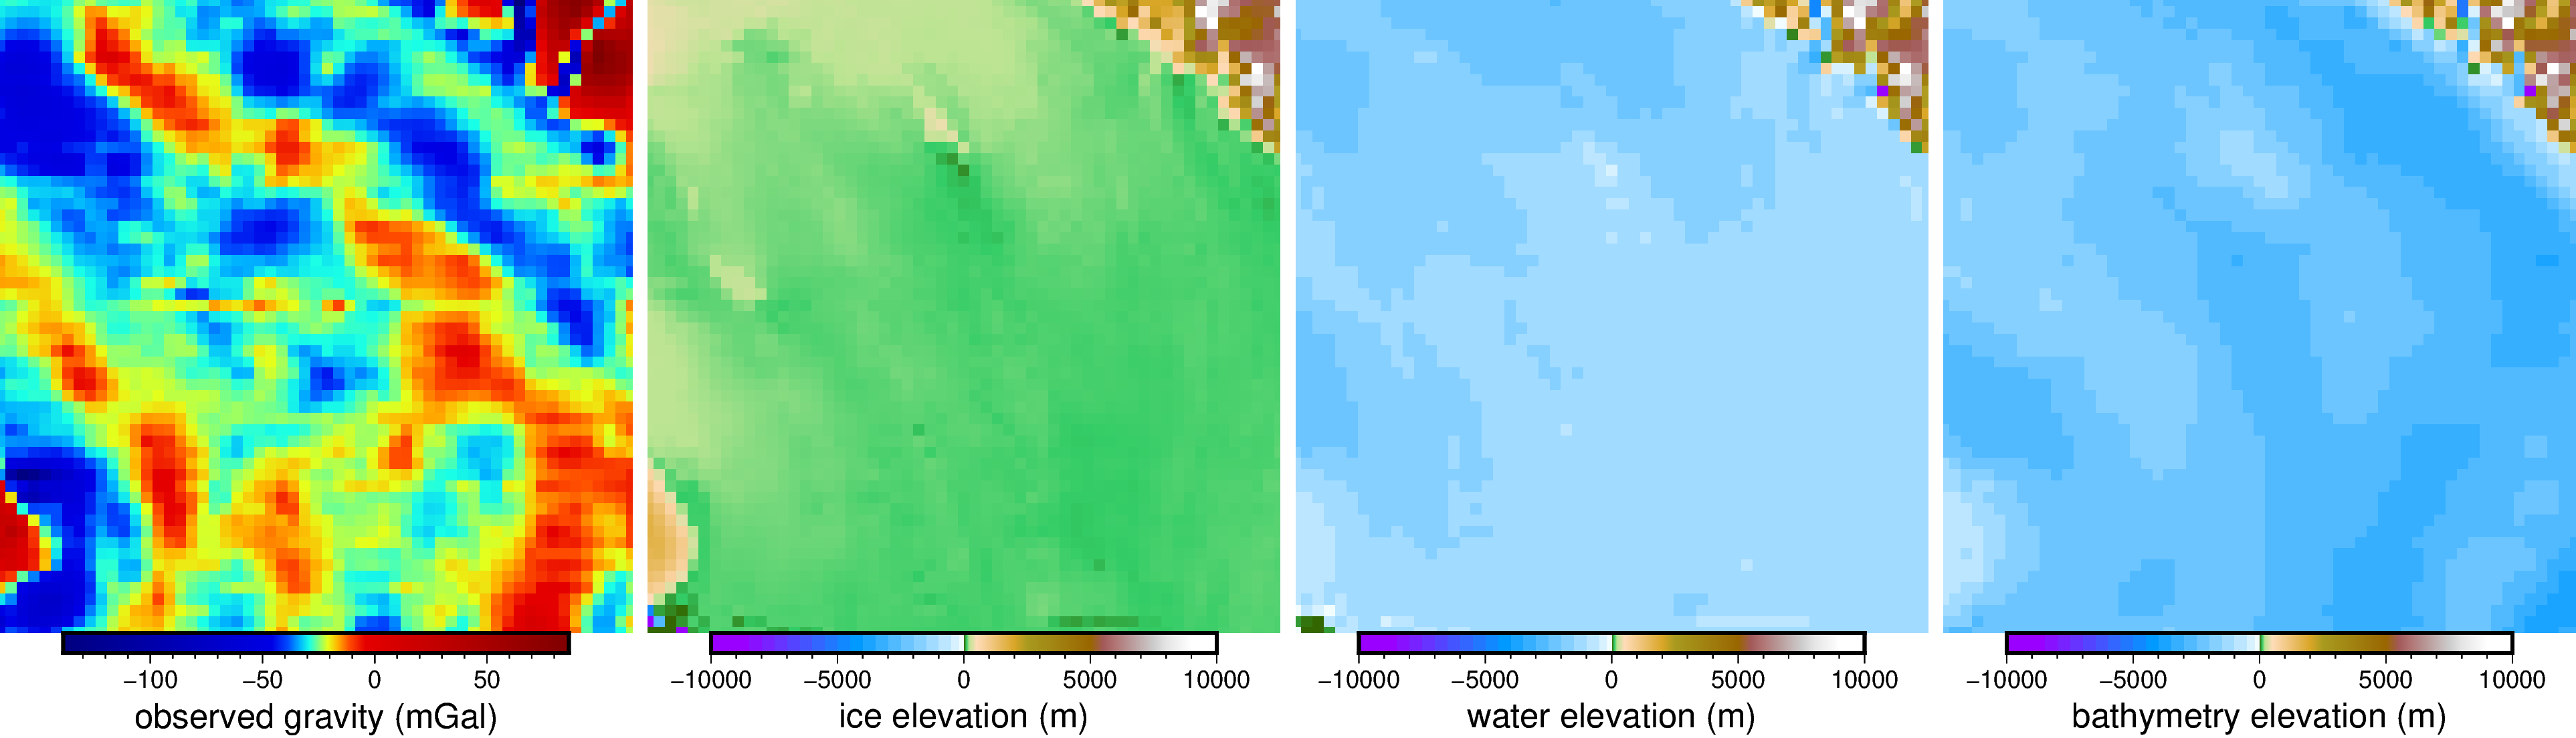

In [4]:
plot_grd(
    grid = grid_grav, 
    cmap = "jet",
    grd2cpt_name = 'grav',
    cbar_label = "observed gravity (mGal)",
    )

for i, (k, v) in enumerate(layers.items()):
    plot_grd(
        grid=layers[k]['grid'], 
        cmap = "globe",
        # grd2cpt_name = 'surface',
        cbar_label = f"{k} elevation (m)",
        origin_shift='xshift',
        )

fig.show()

# Calc forward gravity

In [5]:
def forward_grav_layers(layers, plot=True):
    global Gfor_grid
    # Calculate inital forward gravity model of input layer
    # add density variable to datasets
    for k ,v in layers.items():
        v['grid']['density']=v['grid'].copy()
        v['grid'].density.values[:] = v['rho']

    # list of layers, bottom up
    reversed_layers_list = np.flip(layers_list[:])

    for i, j in enumerate(reversed_layers_list):
        if i == 0:
            layers[j]['prisms']=hm.prism_layer(
                coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                surface=layers[j]['grid'], 
                # reference=-5e3,
                reference = np.nanmin(layers[j]['grid'].values)*2, # bottom of prisms is twice the deepest depth
                properties={'density':layers[j]['grid'].density})
            print(f'{j} top: {np.nanmean(layers[j]["prisms"].top.values)}m and bottom: {np.nanmean(layers[j]["prisms"].bottom.values)}m')

        else:
            if layers[j]['spacing'] != layers[reversed_layers_list[i-1]]['spacing']:
                print(f"resolutions don't match for {j} ({layers[j]['spacing']}m) and {reversed_layers_list[i-1]} ({layers[reversed_layers_list[i-1]]['spacing']}m)")
                print(f"resampling {reversed_layers_list[i-1]} to match {j}")
                tmp = layers[j]['grid'].to_dataframe().reset_index()
                tmp_regrid = pygmt.grdtrack(points = tmp[['x','y']], 
                                            grid = layers[reversed_layers_list[i-1]]['grid'], 
                                            newcolname = 'z_regrid')
                tmp['z_low']=tmp.merge(tmp_regrid, how = 'left', on = ['x','y']).z_regrid
                tmp_grd = pygmt.xyz2grd(tmp[['x','y','z_low']], region = inv_reg, spacing = layers[j]['spacing'])

                layers[j]['prisms']=hm.prism_layer(
                    coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                    surface=layers[j]['grid'], 
                    reference=tmp_grd,
                    properties={'density':layers[j]['grid'].density})
                print(f'{j} top: {np.nanmean(layers[j]["prisms"].top.values)}m and bottom: {np.nanmean(layers[j]["prisms"].bottom.values)}m')
            else:
                layers[j]['prisms']=hm.prism_layer(
                    coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                    surface=layers[j]['grid'], 
                    reference=layers[reversed_layers_list[i-1]]['grid'],
                    properties={'density':layers[j]['grid'].density})
                print(f'{j} top: {np.nanmean(layers[j]["prisms"].top.values)}m and bottom: {np.nanmean(layers[j]["prisms"].bottom.values)}m')

    print('starting forward gravity calculations and gridding')
    for k, v in layers.items():
        df_grav[f'{k}_forward_grav'] = v['prisms'].prism_layer.gravity(
            coordinates = (df_grav.x, df_grav.y, df_grav.z),
            field = 'g_z')
        print(f'finished {k} layer')
        layers[k]['forward_grav'] = pygmt.xyz2grd(data=df_grav[['x','y',f'{k}_forward_grav']],
                            region=fig_reg, spacing=grav_spacing, projection=fig_proj) 

    # add gravity effects of all input layers
    for i, j in enumerate(layers_list):
        if i == 0:
            df_grav['forward_grav_total'] = df_grav[f'{j}_forward_grav']
        else:
            df_grav['forward_grav_total'] += df_grav[f'{j}_forward_grav']
    
    # grid results 
    Gfor_grid = pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_total']],
                                    region=fig_reg, 
                                    spacing=grav_spacing,
                                    projection=fig_proj)
    if plot==True:
        plot_grd(
            grid=Gfor_grid,
            cmap='jet',
            grd2cpt_name='grav',
            cbar_label = f"combined forward gravity (mGal)",)

        for i, (k, v) in enumerate(layers.items()):
            plot_grd(
                grid=v['forward_grav'], 
                cmap = 'jet',
                grd2cpt_name = 'grav',
                cbar_label = f"{k} forward gravity (mGal)",
                origin_shift='xshift',)
            
        fig.show()

bathymetry top: -374.5696105957031m and bottom: -4713.0556640625m
water top: -160.9812469482422m and bottom: -384.3315124511719m
ice top: 243.7149658203125m and bottom: -170.9807586669922m
starting forward gravity calculations and gridding
finished ice layer
finished water layer
finished bathymetry layer


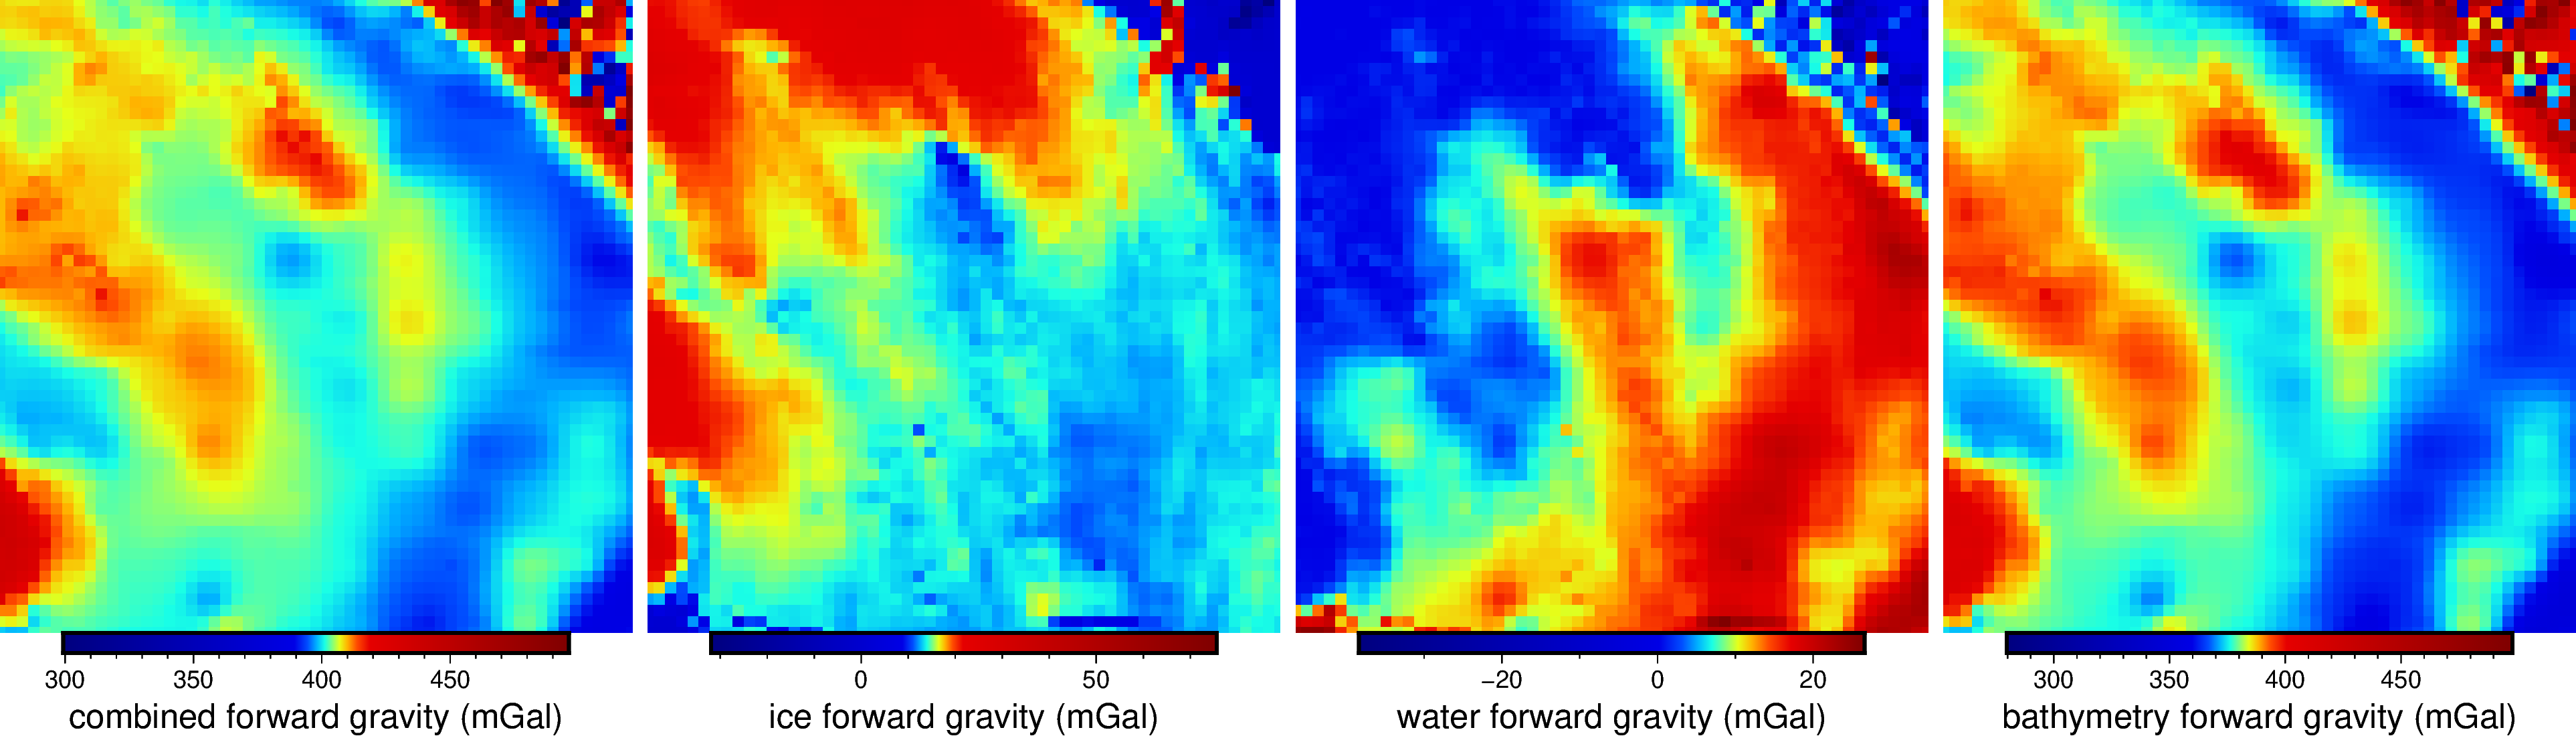

In [6]:
forward_grav_layers(layers, plot=True)

# Calc anomalies

In [7]:
def anomalies(layers, filter='g200e3', plot=True,):  

    forward_grav_layers(layers=layers, plot=False)
    # calculate anomalies in gravity dataframe
    df_grav['initial_misfit'] = df_grav.Gobs - df_grav.forward_grav_total
    shift = df_grav.initial_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean() 
    print(f'average initial misfit within figure region is {int(shift)} mGal')

    df_grav['Gobs_shift'] = df_grav.Gobs - shift
    print(f'average Gobs_shifted: {int(df_grav.Gobs_shift[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean())} mGal')

    df_grav['forward_grav_misfit'] = df_grav.Gobs_shift - df_grav.forward_grav_total
    misfit_shift = df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean() 
    print(f'average misfit between Gobs_shift and forward gravity within figure region is {misfit_shift} mGal')

    # make grids of anomalies
    Gobs_shift_grid = pygmt.xyz2grd(data = df_grav[['x','y','Gobs_shift']],
                                    region=fig_reg, 
                                    spacing=grav_spacing,
                                    projection=fig_proj)

    Gmisfit_grid = pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_misfit']],
                                    region=fig_reg, 
                                    spacing=grav_spacing,
                                    projection=fig_proj)

    Gobs_shift_filt_grid = pygmt.grdfilter(Gobs_shift_grid, filter=filter, distance='0')

    Gmisfit_filt_grid = Gobs_shift_filt_grid - Gfor_grid 

    # # sample Gobs_shift grid at contraint points
    # tmp_regrid = pygmt.grdtrack(points = constraints_df[['x','y']], 
    #                             grid = Gobs_shift_grid,
    #                             newcolname = 'Gobs_sampled')
    # constraints_df['Gobs_shift']=constraints_df.merge(tmp_regrid, how = 'left', on = ['x','y']).Gobs_sampled
    # # grid and interpolate gravity at constraints
    # Gobs_constraints_grid = pygmt.surface(data=constraints_df[['x','y','Gobs_shift']], region=fig_reg, spacing=grav_spacing,)
    # Gmisfit_constraints_grid = Gobs_constraints_grid - Gfor_grid

    # add to dataframe
    # do these need to be transposed??
    df_grav['Gobs_shift_filt'] = Gobs_shift_filt_grid.to_dataframe().reset_index().z
    df_grav['Gmisfit_filt'] = Gmisfit_filt_grid.transpose().to_dataframe().reset_index().z
    # df_grav['Gobs_constraints'] = Gobs_constraints_grid.transpose().to_dataframe().reset_index().z
    # df_grav['Gmisfit_constraints'] = Gmisfit_constraints_grid.transpose().to_dataframe().reset_index().z

    if plot==True:
        grid = Gobs_shift_grid
        plot_grd(grid=grid, cmap='jet', grd2cpt_name='grav',
            cbar_label = "observed gravity (mGal)",)

        # grid = Gobs_constraints_grid
        # plot_grd(grid=grid, cmap='jet', grd2cpt_name='grav', 
        #     cbar_label = "regional gravity (mGal)", origin_shift='xshift',)

        grid = Gobs_shift_filt_grid
        plot_grd(grid=grid, cmap='plotting/grav.cpt', #grd2cpt_name='grav',
            cbar_label = "filtered observed gravity (mGal)", origin_shift='xshift',)

        grid = Gfor_grid
        plot_grd(grid=grid, cmap='plotting/grav.cpt', #grd2cpt_name='grav',
            cbar_label = "forward gravity (mGal)", origin_shift='xshift',)

        grid = Gmisfit_grid
        plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='grav',
            cbar_label = "gravity misfit (mGal)", origin_shift='xshift',)

        # grid = Gmisfit_constraints_grid
        # plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='grav',
        #     cbar_label = "regional gravity misfit (mGal)", origin_shift='xshift',)
        
        grid = Gmisfit_filt_grid
        plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='grav',
            cbar_label = "regional gravity misfit (mGal)", origin_shift='xshift',)
            
        fig.show()

bathymetry top: -374.5696105957031m and bottom: -4713.0556640625m
water top: -160.9812469482422m and bottom: -384.3315124511719m
ice top: 243.7149658203125m and bottom: -170.9807586669922m
starting forward gravity calculations and gridding
finished ice layer
finished water layer
finished bathymetry layer
average initial misfit within figure region is -429 mGal
average Gobs_shifted: 403 mGal
average misfit between Gobs_shift and forward gravity within figure region is -1.55216445689343e-06 mGal


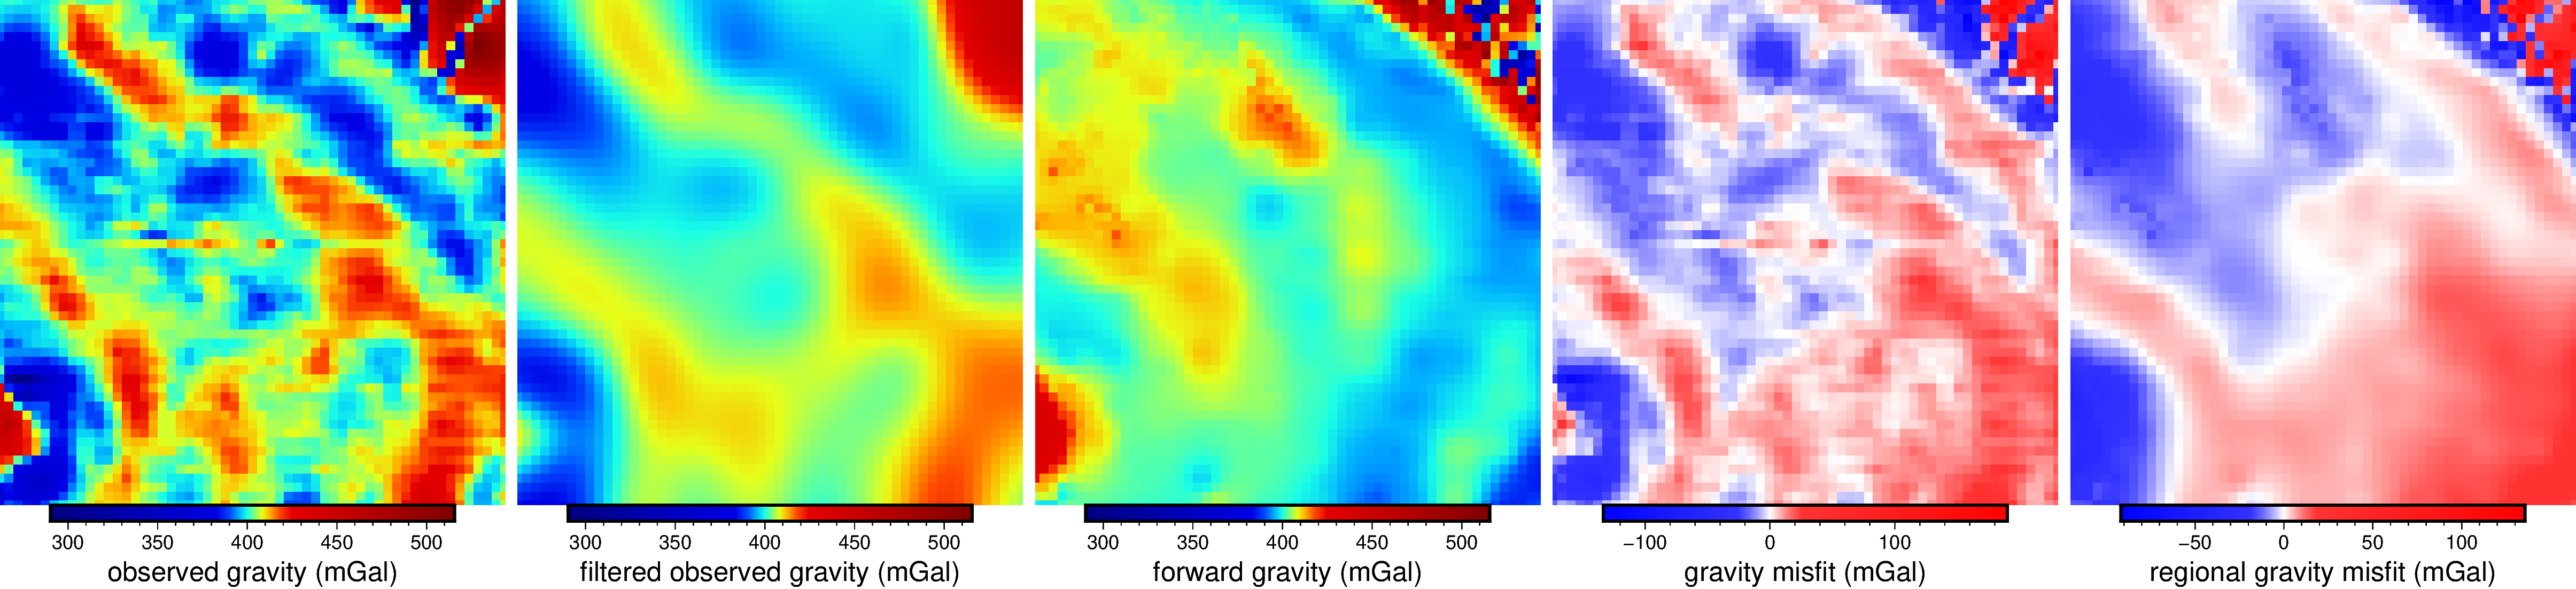

In [8]:
anomalies(layers=layers, plot=True, filter='g200e3')

# Density inversion
We want the density distribution for the basement layer to account for the regional field, so the remaining gravity anomaly, the residual, is used in the geometry-bathy inversion

To do this, will run below density inversion on the basement layer where MISFIT = Gobs at constraint points - forward gravity total

In [9]:
def density_inversion(density_layer, max_density_change=2000,  input_grav=df_grav.Gobs_shift_filt, plot=True):    
    # density in kg/m3

    forward_grav_layers(layers=layers, plot=False)
    spacing = layers[density_layer]['spacing']

    # df_grav['inv_misfit']=df_grav.Gobs_shift-df_grav[f'forward_grav_total']
    df_grav['inv_misfit']=input_grav - df_grav[f'forward_grav_total']

    # get prisms' coordinates from active layer
    prisms = layers[density_layer]['prisms'].to_dataframe().reset_index().dropna()

    print(f'active layer average density: {int(prisms.density.mean())}kg/m3')

    MAT_DENS = (np.zeros([len(input_grav),len(prisms)]))

    initial_RMS = round(np.sqrt((df_grav['inv_misfit'] **2).mean()),2)
    print(f"initial RMS = {initial_RMS}mGal")
    print('calculating sensitivity matrix to determine density correction')

    prisms_n=[]
    for x in range(len(layers[density_layer]['prisms'].easting.values)):
        for y in range(len(layers[density_layer]['prisms'].northing.values)):
            prisms_n.append(layers[density_layer]['prisms'].prism_layer.get_prism((x,y)))
    for col, prism in enumerate(prisms_n):
        MAT_DENS[:, col] = hm.prism_gravity(
            coordinates = (df_grav.x, df_grav.y, df_grav.z),
            prisms = prism,
            density = 1, # unit density
            field = 'g_z',)
    # Calculate shift to prism's densities to minimize misfit     
    Density_correction=lsqr(MAT_DENS,df_grav.inv_misfit,show=False)[0]

    # for i,j in enumerate((input_grav)): #add tqdm for progressbar
    #         MAT_DENS[i,:] = gravbox(
    #                             df_grav.y.iloc[i], df_grav.x.iloc[i], df_grav.z.iloc[i],
    #                             prisms.northing-spacing/2, prisms.northing+spacing/2,
    #                             prisms.easting-spacing/2, prisms.easting+spacing/2,
    #                             prisms.top,  prisms.bottom, np.ones_like(prisms.density))  # unit density, list of ones
    # # Calculate shift to prism's densities to minimize misfit     
    # Density_correction=lsqr(MAT_DENS,df_grav.inv_misfit,show=False)[0]*1000

    # apply max density change
    for i in range(0,len(prisms)):
        if Density_correction[i] > max_density_change:
            Density_correction[i]=max_density_change
        elif Density_correction[i] < -max_density_change:
            Density_correction[i]=-max_density_change

    # resetting the rho values with the above correction
    prisms['density_correction']=Density_correction
    prisms['updated_density']=prisms.density+prisms.density_correction
    dens_correction = pygmt.xyz2grd(x=prisms.easting, y=prisms.northing, z=prisms.density_correction, 
                    region=inv_reg, spacing=grav_spacing, projection=inv_proj)
    dens_update = pygmt.xyz2grd(x=prisms.easting, y=prisms.northing, z=prisms.updated_density, 
                    region=inv_reg, spacing=layers[density_layer]['spacing'], projection=inv_proj)
    initial_misfit = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=fig_reg, spacing=grav_spacing)

    # apply the rho correction to the prism layer
    layers[density_layer]['prisms']['density'].values=dens_update.values
    print(f"average density: {int(layers[density_layer]['prisms'].to_dataframe().reset_index().dropna().density.mean())}kg/m3")
    # recalculate forward gravity of active layer               
    print('calculating updated forward gravity')
    df_grav[f'forward_grav_{density_layer}'] = layers[density_layer]['prisms'].prism_layer.gravity(
            coordinates=(df_grav.x, df_grav.y, df_grav.z),
            field = 'g_z')

    # Recalculate of gravity misfit, i.e., the difference between calculated and observed gravity
    df_grav['forward_grav_total'] = df_grav.forward_grav_total - \
                                    df_grav[f'{density_layer}_forward_grav'] + \
                                    df_grav[f'forward_grav_{density_layer}']
                                    
    df_grav.inv_misfit = input_grav - df_grav.forward_grav_total
    final_RMS = round(np.sqrt((df_grav.inv_misfit **2).mean()),2)
    print(f"RMSE after inversion = {final_RMS}mGal")
    final_misfit = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)

    if plot==True:
        grid = initial_misfit
        plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='misfit',
            cbar_label = f"initial misfit (mGal) [{initial_RMS}]")

        grid = dens_correction
        plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='dens_corr',
            cbar_label = "density correction (kg/m3)", origin_shift='xshift')

        grid = dens_update
        plot_grd(grid=grid, cmap='viridis', grd2cpt_name='dens_update',
            cbar_label = "updated density (kg/m3)", origin_shift='xshift')

        grid = final_misfit
        plot_grd(grid=grid, cmap='polar+h0',# grd2cpt_name='misfit',
            cbar_label = f"final misfit (mGal) [{final_RMS}]", origin_shift='xshift')

        fig.show()

bathymetry top: -374.5696105957031m and bottom: -4713.0556640625m
water top: -160.9812469482422m and bottom: -384.3315124511719m
ice top: 243.7149658203125m and bottom: -170.9807586669922m
starting forward gravity calculations and gridding
finished ice layer
finished water layer
finished bathymetry layer
active layer average density: 2200kg/m3
initial RMS = 14.48mGal
calculating sensitivity matrix to determine density correction
average density: 2201kg/m3
calculating updated forward gravity
RMSE after inversion = 0.19mGal


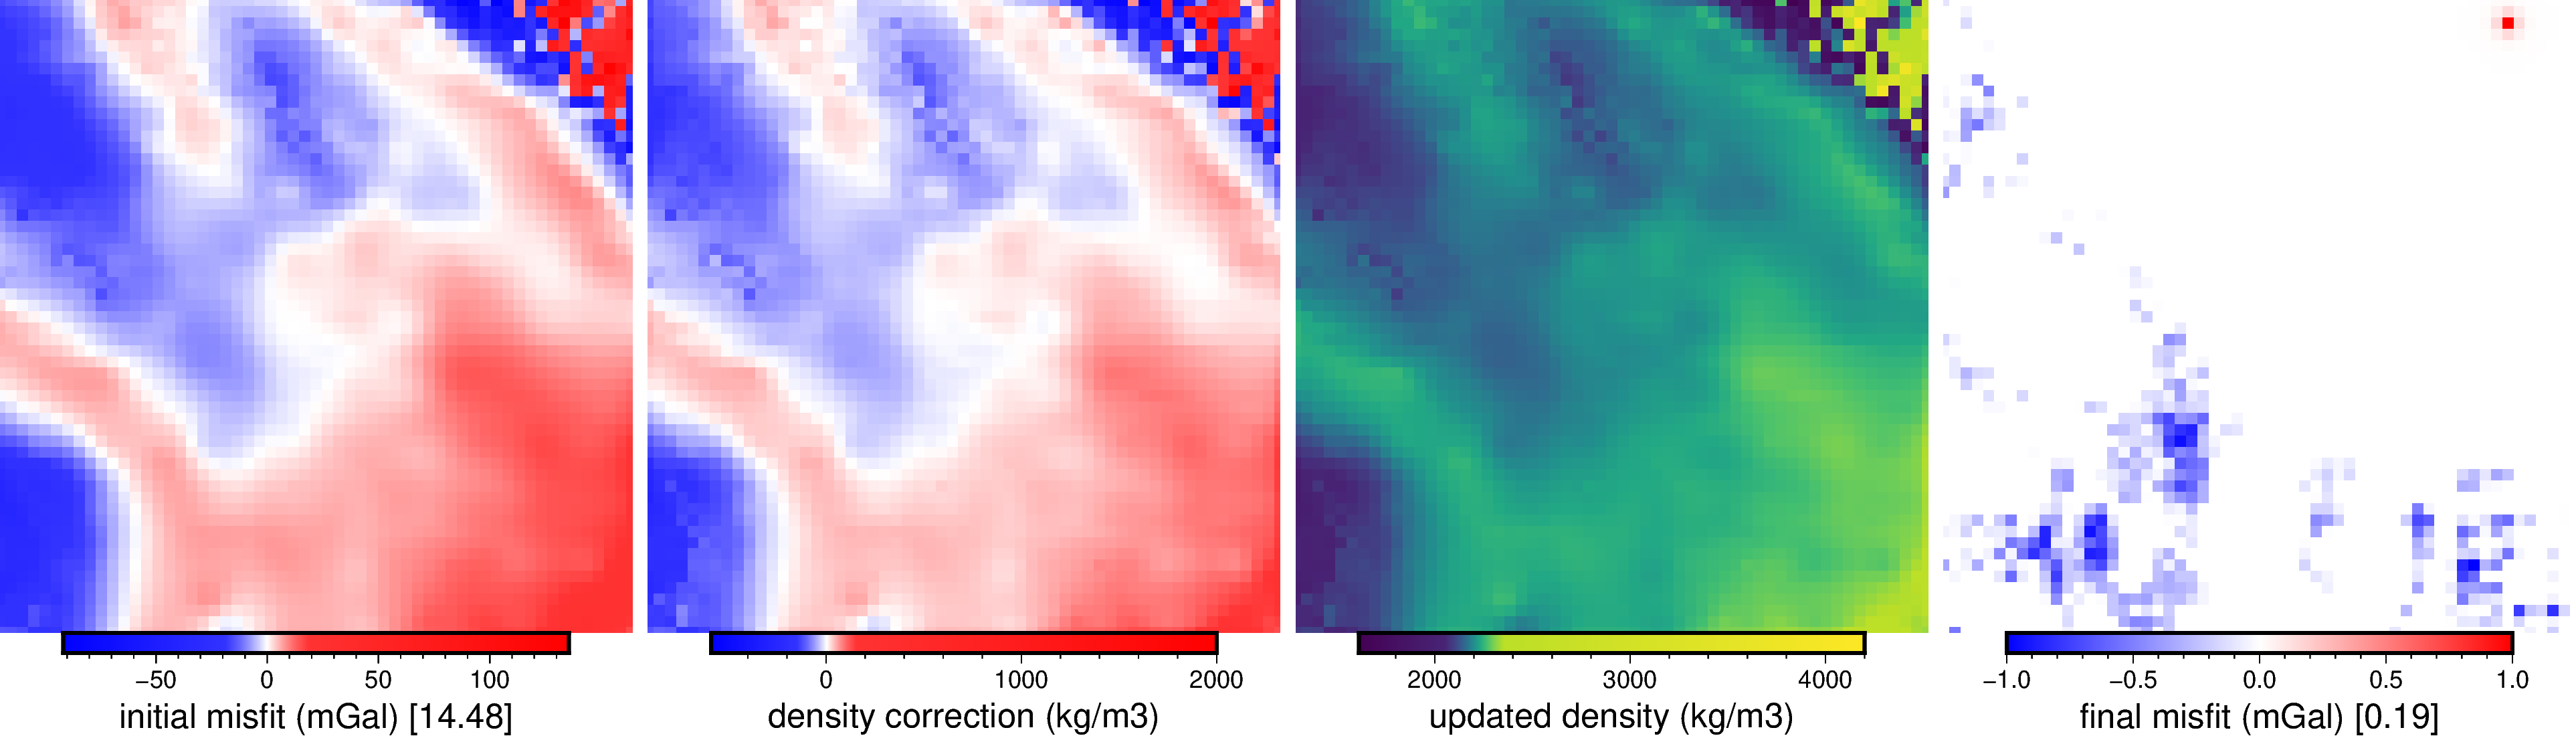

In [10]:
density_inversion(density_layer='bathymetry', plot=True) #10mins, 200km zoom/5k, 3.5mins 400km zoom/5k (113x113 prisms, 33x33 grav)
# notify

# Prism geometry inversion

In [11]:
def geo_inversion(
    constraints, 
    active_layer,
    input_grav = df_grav.Gobs_shift, 
    misfit_sq_tolerance=0.00001,
    delta_misfit_squared_tolerance=0.002,
    Max_Iterations=5,
    max_layer_change_per_iter=100, #meters
    plot=True):

    prisms = layers[active_layer]['prisms'].to_dataframe().reset_index().dropna()
    df_grav['inv_misfit'] = input_grav - df_grav.forward_grav_total
    spacing = layers[active_layer]['spacing'] 
    misfit_squared_updated=np.Inf  # positive infinity
    delta_misfit_squared=np.Inf  # positive infinity

    ITER=0
    # while delta_misfit_squared (inf) is greater than 1 + least squares tolerance (0.02)
    while delta_misfit_squared > 1+delta_misfit_squared_tolerance:
        ITER+=1 
        print(f"##################################\n iteration {ITER}")
        # get prisms' coordinates from active layer and layer above
        prisms = layers[active_layer]['prisms'].to_dataframe().reset_index().dropna()
        ind = layers_list.index(active_layer)
        prisms_above = layers[layers_list[ind-1]]['prisms'].to_dataframe().reset_index().dropna()
        print(f'active layer average depth: {int(prisms.top.mean())}m')

        # calculate jacobian with grav_column_der
        jacobian = (np.zeros([len(input_grav),len(prisms)]))
        initial_RMS = round(np.sqrt((df_grav.inv_misfit **2).mean()),2)
        print(f"initial RMS = {initial_RMS}mGal")
        # print('calculating Jacobian matrix to determine surface correction')
        for i,j in enumerate((input_grav)):
            # Calculation of the Jacobian matrix using the annular cylinder approximation (grav_column_der)
            #jacobian is matrix array with NG number of rows and NBath+NBase+NM number of columns
            # uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
            jacobian[i,:]=grav_column_der(
                                        df_grav.y.iloc[i], # coords of gravity observation points
                                        df_grav.x.iloc[i],
                                        df_grav.z.iloc[i],  
                                        prisms.northing, prisms.easting,     
                                        prisms.top, 
                                        prisms.bottom,
                                        spacing,     
                                        prisms.density/1000)  # jacobian[i,0:NBath] is i'th row and columns 0 to NBath
        # Calculate shift to prism's tops to minimize misfit
        # gives the amount that each column's Z1 needs to change by to have the smallest misfit
        Surface_correction=lsqr(jacobian,df_grav.inv_misfit,show=False)[0] # finds the least-squares solution to jacobian and Grav_Misfit, assigns the first value to Surface_correction

        # if necesarry correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Surface_correction
        for i in range(0,len(prisms)):
            if Surface_correction[i] > max_layer_change_per_iter:
                Surface_correction[i]=max_layer_change_per_iter
            elif Surface_correction[i] < -max_layer_change_per_iter:
                Surface_correction[i]=-max_layer_change_per_iter
        prisms['surface_correction']=Surface_correction
        prisms_above['surface_correction']=Surface_correction

        # add constraints to dataframe
        prisms['constraints']=constraints_grid.to_dataframe().reset_index().z
        prisms_above['constraints']=constraints_grid.to_dataframe().reset_index().z
        
        # apply above surface corrections 
        if constraints==True:
            prisms.top += prisms.surface_correction * prisms.constraints
            prisms_above.bottom += prisms_above.surface_correction * prisms_above.constraints
        else:
            print('constraints not applied')
            prisms.top += prisms.surface_correction
            prisms_above.bottom += prisms_above.surface_correction

        # apply the z correction to the active prism layer and the above layer with Harmonica 
        prisms_grid = pygmt.xyz2grd(prisms[['easting','northing','top']],region=inv_reg, spacing=spacing)
        prisms_above_grid = pygmt.xyz2grd(prisms_above[['easting','northing','bottom']], region=inv_reg, spacing=spacing)
        layers[active_layer]['prisms'].prism_layer.update_top_bottom(
                        surface = prisms_grid, 
                        reference = layers[active_layer]['prisms'].bottom)
        layers[layers_list[ind-1]]['prisms'].prism_layer.update_top_bottom(
                        surface = layers[layers_list[ind-1]]['prisms'].top, 
                        reference = prisms_above_grid)
        
        initial_misfit = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)
        iter_corr = pygmt.xyz2grd(
            x=prisms.easting,y=prisms.northing, z=prisms.surface_correction, region=inv_reg, spacing=spacing)
        iter_corr_constrained = pygmt.xyz2grd(
            x=prisms.easting,y=prisms.northing, z=prisms.surface_correction*prisms.constraints, region=inv_reg, spacing=spacing)
        
        print('calculating updated forward gravity')
        df_grav[f'{active_layer}_forward_grav'] = layers[active_layer]['prisms'].prism_layer.gravity(
                coordinates=(df_grav.x, df_grav.y, df_grav.z),
                field = 'g_z')
        df_grav[f'{layers_list[ind-1]}_forward_grav'] = layers[layers_list[ind-1]]['prisms'].prism_layer.gravity(
            coordinates=(df_grav.x, df_grav.y, df_grav.z),
            field = 'g_z')

        # Calculation of gravity misfit, i.e., the difference between calculated and observed gravity
        # replace previous forward grav of layer with newly calculated forward grav
        # df_grav.forward_grav_total += \
        #                 (df_grav[f'{active_layer}_forward_grav'] - \
        #                 df_grav[f'{layers_list[ind-1]}_forward_grav'] + \
        #                 df_grav[f'forward_grav_{active_layer}']  + \
        #                 df_grav[f'forward_grav_{layers_list[ind-1]}'])
        for i, j in enumerate(layers_list):
            if i == 0:
                df_grav['forward_grav_total'] = df_grav[f'{j}_forward_grav']
            else:
                df_grav['forward_grav_total'] += df_grav[f'{j}_forward_grav']

        df_grav['inv_misfit'] = input_grav - df_grav.forward_grav_total
        final_RMS = round(np.sqrt((df_grav.inv_misfit **2).mean()),2)
        print(f"RMSE after iteration {ITER} = {final_RMS}mGal")
        # for first iteration, divide infinity by mean square of gravity residuals, inversion will stop once this gets to delta_misfit_squared_tolerance (0.02)
        misfit_sq=np.mean(df_grav.inv_misfit**2)
        delta_misfit_squared=misfit_squared_updated/misfit_sq
        misfit_squared_updated=misfit_sq # updated 
        layers[active_layer]['inv_grid']=pygmt.xyz2grd(prisms[['easting','northing','top']], region=inv_reg, spacing=spacing)
        
        final_Gfor = pygmt.xyz2grd(df_grav[['x','y','forward_grav_total']], region=inv_reg, spacing=grav_spacing)
        final_misfit = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)
        difference = layers[active_layer]['inv_grid'] - layers[active_layer]['grid']

        if plot==True:
            grid = initial_misfit
            if ITER ==1:
                plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='misfit',
                    cbar_label = f"initial misfit (mGal) [{initial_RMS}]", origin_shift='initialize')
            else:
                plot_grd(grid=grid, cmap='plotting/misfit.cpt',
                    cbar_label = f"initial misfit (mGal) [{initial_RMS}]", origin_shift='yshift')

            grid=layers[active_layer]['inv_grid']
            plot_grd(grid=grid, cmap='globe',
                cbar_label = "updated bathymetry (m)", origin_shift='xshift')

            grid = iter_corr
            if ITER == 1:
                plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='corr',
                    cbar_label = "iteration correction (m)", origin_shift='xshift')
            else:
                plot_grd(grid=grid, cmap='plotting/corr.cpt',
                    cbar_label = "iteration correction (m)", origin_shift='xshift')

            grid = difference 
            if ITER ==1:
                plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='diff',
                    cbar_label = f"total {active_layer} difference (m)", origin_shift='xshift')
            else:
                plot_grd(grid=grid, cmap='plotting/diff.cpt',
                    cbar_label = f"total {active_layer} difference (m)", origin_shift='xshift')

            grid = final_misfit
            plot_grd(grid=grid, cmap='plotting/misfit.cpt',
                cbar_label = f"final gravity misfit (mGal) [{final_RMS}]", origin_shift='xshift')
        
            # plot iteration label
            fig.shift_origin(xshift=((plot_width)/10))
            fig.text(projection = projection, 
                position='ML',
                justify='ML',
                text = f"It. #{ITER}",
                font = '30p,Helvetica,black',
                clearance = '+tO')
            fig.shift_origin(xshift=-((plot_width)/10))
            
            # shift back to origin 
            fig.shift_origin(xshift=-4*((plot_width + 2)/10))

            if ITER == Max_Iterations:
                print(f"Inversion terminated after {ITER} iterations with least-squares norm={int(misfit_sq)} because maximum number of iterations ({Max_Iterations}) reached")
                break
            if misfit_sq < misfit_sq_tolerance:
                print(f"Inversion terminated after {ITER} iterations with least-squares norm={int(misfit_sq)} because least-squares norm < {misfit_sq_tolerance}")
                break

    fig.show()

    # end of inversion iteration WHILE loop
    if delta_misfit_squared < 1+delta_misfit_squared_tolerance:
        print("terminated - no significant variation in least-squares norm ")

##################################
 iteration 1
active layer average depth: -374m
initial RMS = 10.75mGal
constraints not applied
calculating updated forward gravity
RMSE after iteration 1 = 8.6mGal
##################################
 iteration 2
active layer average depth: -375m
initial RMS = 8.6mGal
constraints not applied
calculating updated forward gravity
RMSE after iteration 2 = 7.3mGal
##################################
 iteration 3
active layer average depth: -378m
initial RMS = 7.3mGal
constraints not applied
calculating updated forward gravity
RMSE after iteration 3 = 6.19mGal
Inversion terminated after 3 iterations with least-squares norm=38 because maximum number of iterations (3) reached


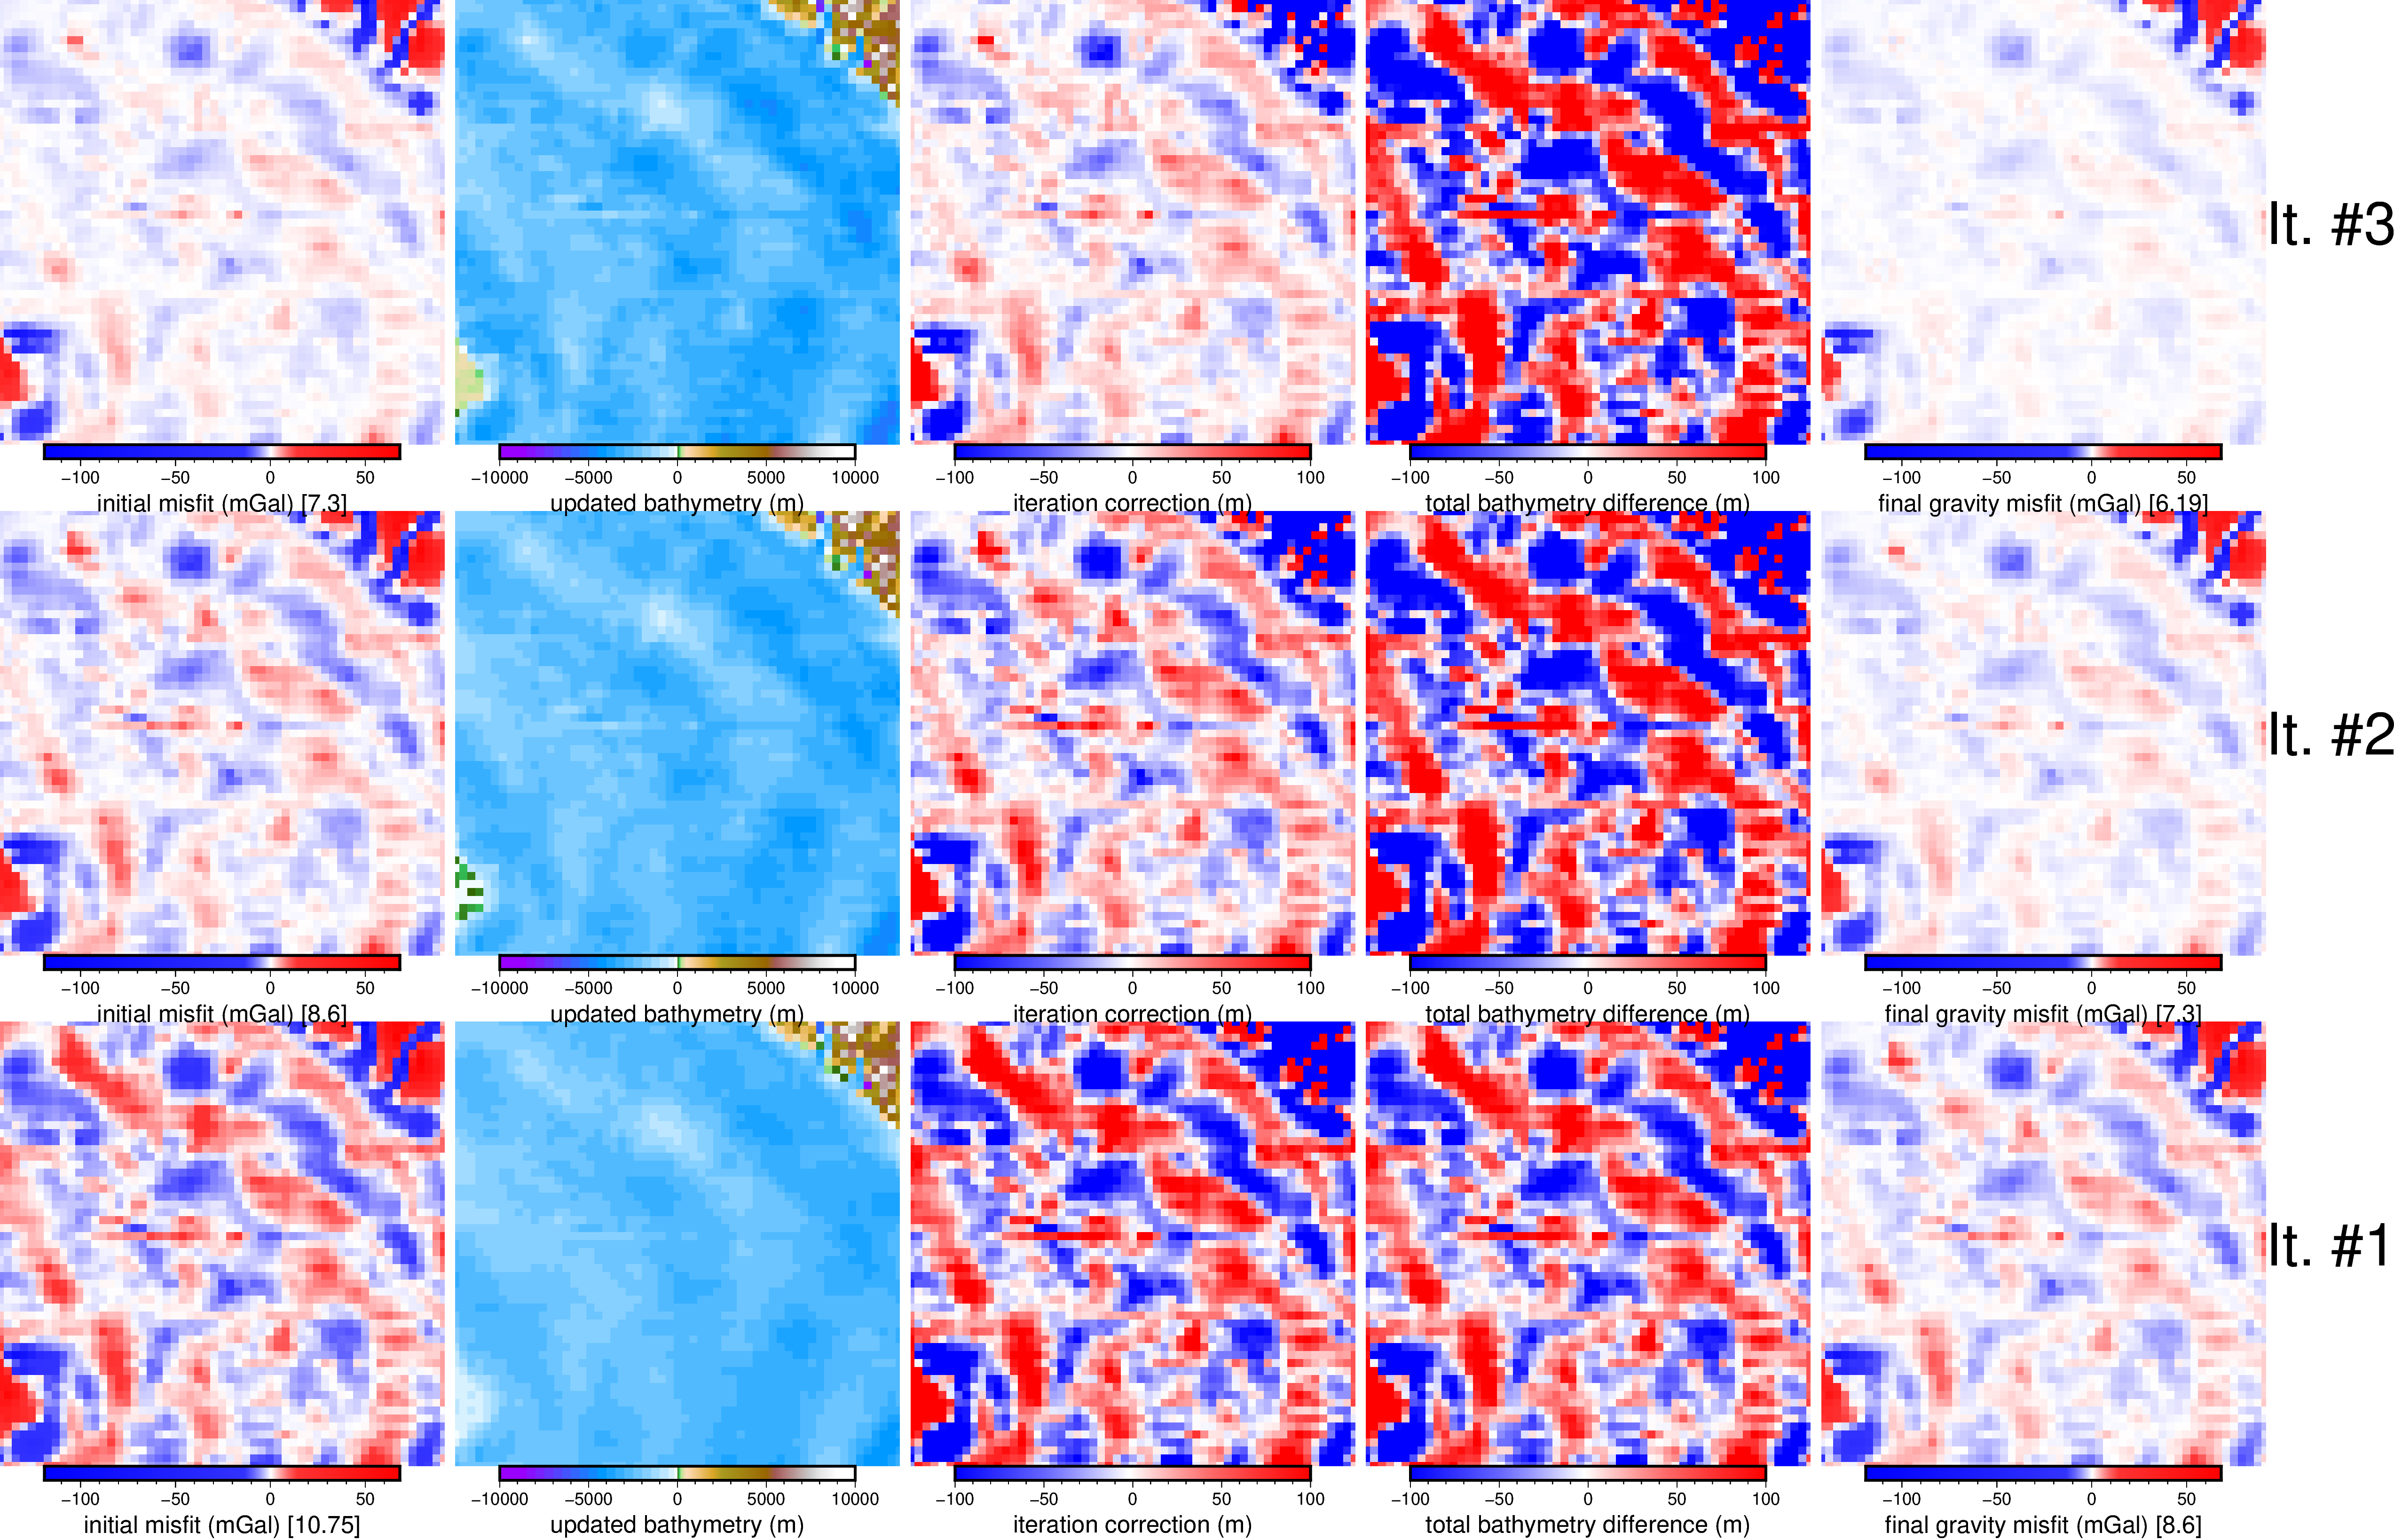

In [12]:
geo_inversion(
    constraints=False, 
    active_layer=active_layer,    
    Max_Iterations=3,
    max_layer_change_per_iter=100,
    ) 
# 15 mins 200km zoom/5k, 7mins 400kmzoom/5k (113x113 prisms, 33x33 grav)
# notify

# Bottom

In [ ]:
# Fabio's test grids
# inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_gravity_10000m_lr.nc -Ginversion_layers/gravity_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_ice_10000m_lr.nc -Ginversion_layers/BedMachine_surface_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_water_10000m_lr.nc -Ginversion_layers/BedMachine_icebase_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_layer1_10000m_lr.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_reg_str} -rg -I20e3  inversion_layers/base_RIS_layer2_20000m_lr.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 

# surface = xr.load_dataarray("../inversion_layers/BedMachine_surface_5k_filled.nc")
# icebase = xr.load_dataarray("../inversion_layers/BedMachine_icebase_5k_filled.nc")
# bed = xr.load_dataarray("../inversion_layers/BedMachine_bed_5k.nc")
# basement = xr.load_dataarray("../inversion_layers/ROSETTA_basement_BedMachine_bed.nc", drop_variables='polar_stereographic')
# grav = xr.load_dataset('inversion_layers/gravity_inv.nc')

# surface = xr.load_dataset('inversion_layers/BedMachine_surface_filled_inv.nc')
# icebase = xr.load_dataset('inversion_layers/BedMachine_icebase_filled_inv.nc')
# bed = xr.load_dataset('inversion_layers/BedMachine_bed_inv.nc')
# basement = xr.load_dataset('inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc')

# df_grav=grav.to_dataframe().reset_index()
# df_grav.rename(columns={'z':'Gobs'}, inplace=True)
# # df_grav['z']=750
# df_grav['z']=surface.to_dataframe().reset_index().z+750
# df_grav

In [ ]:
# TREND_TYPE = 'Constant value'
# # TREND_TYPE = 'Linear'
# # TREND_TYPE = 'Full regional correction'

# # set type of regional correction
# if TREND_TYPE == "Constant value":
#     df_grav['regional_grav'] = df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean()
#     # df_grav['regional_grav'] = df_grav.forward_grav_misfit.mean()
#     print(df_grav['regional_grav'].mean())

# elif TREND_TYPE == 'Linear':
#     # ATEMP=np.column_stack((np.ones(len(df_grav.Gobs[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])), 
#     #                         df_grav.y[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))]))
#     #                         df_grav.x[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))], 
#     # C,RESID,RANK,SIGMA=np.linalg.lstsq(ATEMP,df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])
#     # df_grav['regional_grav'] = C[0]*np.ones(len(df_grav.Gobs[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])) + C[1]*df_grav.y[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))] + C[2]*df_grav.x[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))]
#     ATEMP=np.column_stack((np.ones(len(df_grav.Gobs)), 
#                             df_grav.x, 
#                             df_grav.y))
#     C,RESID,RANK,SIGMA=np.linalg.lstsq(ATEMP,df_grav.forward_grav_misfit)
#     df_grav['regional_grav'] = C[0]*np.ones(len(df_grav.Gobs)) + C[1]*df_grav.y + C[2]*df_grav.x
#     # print(C[0])
    
# elif TREND_TYPE == 'Full regional correction':
#      df_grav['regional_grav'] = df_grav.forward_grav_misfit

# # calculate residual gravity to be inverted
# df_grav['residual_grav'] = df_grav.Gobs - df_grav.regional_grav 

# residual_grav_grid=pygmt.surface(data = df_grav[['x','y','residual_grav']],
#                                  region=inv_reg, 
#                                  spacing=grav_spacing, 
#                                  M='1c', 
#                                  registration='g')

# regional_grav_grid=pygmt.surface(data = df_grav[['x','y','regional_grav']],
#                                  region=inv_reg, 
#                                  spacing=grav_spacing, 
#                                  M='1c', 
#                                  registration='g')

# # plot the grids
# fig = pygmt.Figure()

# # plot observed gravity
# data=grid_grav.z
# pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
# fig.grdimage(
#         data,
#         cmap=True,
#         projection=fig_proj, 
#         region=fig_reg,
#         nan_transparent=True,
#         frame=['+gwhite'])
# fig.colorbar(cmap=True, frame='af+l"observed gravity (mGal)"')
# # plot later figure extents (without inv buffer)
# fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
#             y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
#             pen = '1p,black')

# # plot regional gravity
# fig.shift_origin(xshift=(fig_width)/10)
# data=regional_grav_grid
# try:
#     pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
#     # pygmt.makecpt(cmap="jet", series=[data.min().item(), data.max().item()], background=True)
# except:
#     pass
# fig.grdimage(
#     data,
#     cmap=True,
#     projection=fig_proj, 
#     region=fig_reg,
#     nan_transparent=True,
#     frame=['+gwhite'])
# fig.colorbar(cmap=True, frame='af+l"regional gravity (mGal)"')
# # plot later figure extents (without inv buffer)
# fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
#             y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
#             pen = '1p,black')

# # plot residual gravity
# fig.shift_origin(xshift=(fig_width+1)/10)
# data=residual_grav_grid
# pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
# fig.grdimage(
#     data,
#     cmap=True,
#     projection=fig_proj, 
#     region=fig_reg,
#     nan_transparent=True,
#     frame=['+gwhite'])
# fig.colorbar(cmap=True, frame='af+l"residual gravity (mGal)"')
# # plot later figure extents (without inv buffer)
# fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
#             y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
#             pen = '1p,black')

# fig.show()
# df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].describe()

In [ ]:
# #########
# active_layer = 'bathymetry'
# #########

# df_grav['grav_inversion']=df_grav.Gobs_shift

# df = layers[active_layer]['prisms'].to_dataframe().reset_index()

# jacobian = (np.zeros([len(df_grav),len(df)])) # array with NG number of rows and NBath+NBase+NM number of columns


# spacing = layers[active_layer]['spacing'] 

# for i,j in enumerate(tqdm(df_grav.Gobs)):
#     # Calculation of the Jacobian matrix using the annular cylinder approximation (grav_column_der)
#     #jacobian is matrix array with NG number of rows and NBath+NBase+NM number of columns
#     # uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
#     jacobian[i,0:len(df)]=grav_column_der(df_grav.y.iloc[i], # coords of gravity observation points
#                                             df_grav.x.iloc[i],
#                                             df_grav.z.iloc[i],  
#                                             df.northing, df.easting,     
#                                             df.top, 
#                                             df.bottom,
#                                             spacing,     
#                                             df.density/1000)  # jacobian[i,0:NBath] is i'th row and columns 0 to NBath
# jacobian

In [ ]:
# same as above but with matplotlib
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(ncols=1+len(layers), figsize=(5*(1+len(layers)),4))

# # GRAVITY PLOT
# grid_grav.z.plot(ax=axes[0], cmap='coolwarm', robust=True)
# axes[0].set_title('Observed gravity')

# # LAYERS PLOTS
# for i, (k, v) in enumerate(layers.items()):
#     layers[k]['grid'].z.plot(ax=axes[i+1], cmap='terrain', vmin=-10000, vmax=10000, center=0, robust=True)
#     axes[i+1].set_title(f'{k} elevation')

# # ALL PLOTS
# for i in axes:
#     i.set_aspect('equal')
#     i.add_patch(mpl.patches.Rectangle(
#     (e_fig, n_fig), w_fig-e_fig, s_fig-n_fig, lw=2, fill=False) ) 

# plt.tight_layout()


In [ ]:
# Fabio's test grids
# !gmt grdsample -R{inv_reg_str} -rg -I{grav_spacing}  inversion_layers/base_RIS_gravity_10000m_lr.nc -Ginversion_layers/gravity_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[0]}  inversion_layers/base_RIS_ice_10000m_lr.nc -Ginversion_layers/BedMachine_surface_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[1]}  inversion_layers/base_RIS_water_10000m_lr.nc -Ginversion_layers/BedMachine_icebase_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[2]}  inversion_layers/base_RIS_layer1_10000m_lr.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[3]}  inversion_layers/base_RIS_layer2_20000m_lr.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 


In [ ]:
# active_layer='bathymetry'

# layers_list =[
#              'ice',
#              'water',
#              'bathymetry',
#              'basement',
#             #  'moho'
# ]
# spacing_list = [
#                 20e3,
#                 20e3,
#                 20e3,
#                 20e3,
#                 # 20e3
# ]
# rho_list = [
#             920,
#             1030,
#             2200,
#             2800,
#             # 3300
# ]

# grav_spacing = 20e3

# fig_reg_str=f'{e_fig}/{w_fig}/{n_fig}/{s_fig}'
# # inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'
# # resample gravity to just within the figure region (without buffer)
# !gmt grdsample -R{fig_reg_str} -rg -Vn -I{grav_spacing}  gravity_data/ant4d_gravity.nc -Ginversion_layers/gravity_inv.nc

# # resample layer grids to inversion region (with buffer)
# # surface (ice)
# !gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[0]}  inversion_layers/bedmachine/BedMachine_surface_5k_filled.nc -Ginversion_layers/BedMachine_surface_filled_inv.nc
# # icebase (water)
# !gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[1]}  inversion_layers/bedmachine/BedMachine_icebase_5k_filled.nc -Ginversion_layers/BedMachine_icebase_filled_inv.nc
# # bathymetry (sediment)
# !gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[2]}  bathymetry_data/bedmap_bedmachine_RIGGS_grd_fill.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# # !gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[2]}  inversion_layers/bedmachine/BedMachine_bed_5k.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# # basement (crust)
# !gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[3]}  inversion_layers/ANTASed_mag_basement_filled.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 
# # !gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[3]}  inversion_layers/RE_basement_BedMachinebed_filled.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 
# # moho (mantle)
# # !gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[4]}  /Volumes/arc_04/tankerma/Datasets/An_et_al_2015/AN1-MOHO.nc -Ginversion_layers/moho_inv.nc 

# # add constraints grid
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[layers_list.index(active_layer)]} constraints_grid/constraints_grid.nc -Gconstraints_grid/constraints_grid_resample.nc 
# fname = 'constraints_grid/constraints_grid_resample.nc'
# constraints_grid = xr.load_dataset(fname)

# # add bathymetry control points
# fname = 'bathymetry_data/bedmachine_RIGGS.csv'
# constraints_df =  pd.read_csv(fname, index_col=False)

# !gmt grdmask plotting/MEaSUREs_RIS.shp -Gplotting/RIS_GL_mask_outer.nc -I1000 -R{inv_reg_str} -NNaN/NaN/1
# constraints_RIS_df = pygmt.select(data=constraints_df, gridmask='plotting/RIS_GL_mask_outer.nc')

# fname_list=[
#             'inversion_layers/BedMachine_surface_filled_inv.nc',
#             'inversion_layers/BedMachine_icebase_filled_inv.nc',
#             'inversion_layers/BedMachine_bed_inv.nc',
#             'inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc',
#             # 'inversion_layers/moho_inv.nc'
#             ]

# layers = {j:{'spacing':spacing_list[i], 
#             'fname':fname_list[i], 
#             'rho':rho_list[i]} for i, j in enumerate(layers_list)}

# for k, v in layers.items():
#     v['grid']=xr.load_dataset(v['fname'])
#     v['df']=xr.load_dataset(v['fname']).to_dataframe().reset_index()
#     v['df']['rho']=v['rho']
#     v['df'].dropna(how='any', inplace=True)
#     v['len']=len(v['df'].x)  

# fname='inversion_layers/gravity_inv.nc'
# grid_grav = xr.load_dataset(fname)           
# df_grav = xr.load_dataset(fname).to_dataframe().reset_index() 
# df_grav.rename(columns={'z':'Gobs'}, inplace=True)
# df_grav.dropna(how='any', inplace=True)
# df_grav['z']=layers['ice']['grid'].to_dataframe().reset_index().z+750

# for k, v in layers.items():
#     print(f"{k}: {v['len']} points") 

# print(f'gravity: {len(df_grav)} points')    
# print(f'bathymetry control points:{len(constraints_df)}')    

In [ ]:
# from pygmt import session_management
# session_management.end()
# session_management.begin()
